## Data reading and Data Insights

**Indoor Plants Participant: fenuar7d, 32 days participation**

*Dataset:* 'Indoor Plants' vs 'No Indoor Plants' study




#### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan

In [3]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_indoor_plants_-_fenuar7d_2025-05-18 22_08_31.085//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_indoor_plants_-_fenuar7d_2025-05-18 22_08_31.085//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: fenuar7d
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [4]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: '21af6390-f69a-48d3-9033-9150527ad76b'


#### Participation of the study

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  21af6390-f69a-48d3-9033-9150527ad76b                  32


As anticipated, the study comprised a single participant, with a total participation period of 32 days.

#### Missing Values

In [6]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),            
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 21af6390-f69a-48d3-9033-9150527ad76b ---

  Outcome:
    Start date:           2025-04-15
    End of expected 16d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  Mediators:
    Start date:           2025-04-15
    End of expected 16d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0


#### Remove Participants Who Joined Outside the Study

In [7]:
# df_mea = df_mea[df_mea['participant_id'] != "ca773388-eb42-4716-995a-476ed72c0475"]
# df_mea.shape[0]

#### Data Preperation

In [8]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-05-16 19:45:55.720866+00:00,Mediators,21af6390-f69a-48d3-9033-9150527ad76b,31,No indoor plants!,NaN,NaN,NaN,NaN,6.0,7.0


In [9]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [10]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [11]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
63,2025-04-15 19:09:35.980581+00:00,Outcome,21af6390-f69a-48d3-9033-9150527ad76b,0,Indoor plants!,7.0,6.0,8.0,1.0,NaN,NaN
61,2025-04-16 19:11:28.393330+00:00,Outcome,21af6390-f69a-48d3-9033-9150527ad76b,1,Indoor plants!,7.0,7.0,8.0,1.0,NaN,NaN
59,2025-04-17 19:09:20.120171+00:00,Outcome,21af6390-f69a-48d3-9033-9150527ad76b,2,Indoor plants!,7.0,6.0,8.0,1.0,NaN,NaN
57,2025-04-18 19:00:27.504584+00:00,Outcome,21af6390-f69a-48d3-9033-9150527ad76b,3,Indoor plants!,6.0,5.0,8.0,1.0,NaN,NaN
55,2025-04-19 19:06:29.711005+00:00,Outcome,21af6390-f69a-48d3-9033-9150527ad76b,4,No indoor plants!,5.0,5.0,1.0,6.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)   

#### Data Shape

In [12]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 32
Columns: 11


#### Data Types of columns

In [13]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [14]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue
        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),       
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 32d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 21af6390-f69a-48d3-9033-9150527ad76b ---

  Outcome:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  Mediators:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  survey1_question1_response:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  survey1_question2_response:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  survey1_question3_response:
    Start date:           2025-04-15
    End of expected 32d:  2025-05-16
    Expected days count:  32
    Completed days count: 32
    Missed days count:    0

  survey1_question4_re

#### Missing Values for Confirmations between 08.00 - 21.00

In [15]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=32, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 32 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

All 32 days have participation confirmations; no missing days found.


#### Summary Statistics

In [16]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             32.000000                   32.000000   
mean              15.500000                    6.656250   
std                9.380832                    1.450459   
min                0.000000                    3.000000   
25%                7.750000                    6.000000   
50%               15.500000                    7.000000   
75%               23.250000                    7.000000   
max               31.000000                    9.000000   

       survey1_question2_response  survey1_question3_response  \
count                   32.000000                   32.000000   
mean                     6.562500                    3.906250   
std                      1.501343                    3.093796   
min                      3.000000                    1.000000   
25%                      5.750000                    1.000000   
50%                      6.500000               

In [17]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 63 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            32 non-null     datetime64[ns, UTC]
 1   measurement_name            32 non-null     object             
 2   participant_id              32 non-null     object             
 3   current_day_of_study        32 non-null     int64              
 4   current_intervention_name   32 non-null     object             
 5   survey1_question1_response  32 non-null     float64            
 6   survey1_question2_response  32 non-null     float64            
 7   survey1_question3_response  32 non-null     float64            
 8   survey1_question4_response  32 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

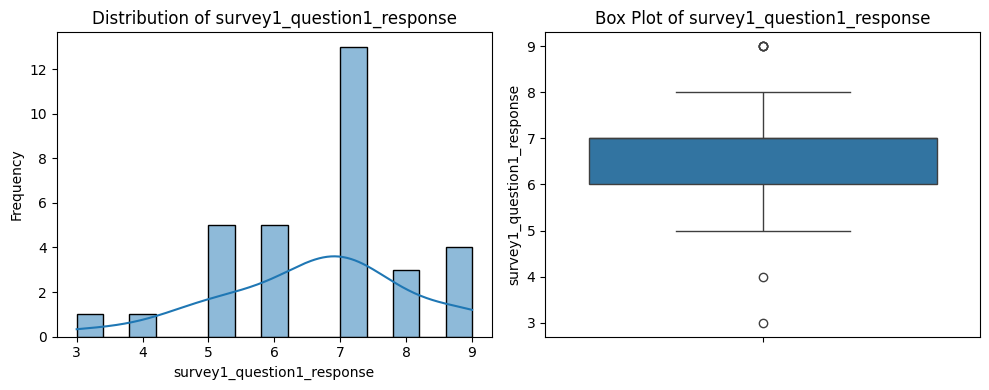

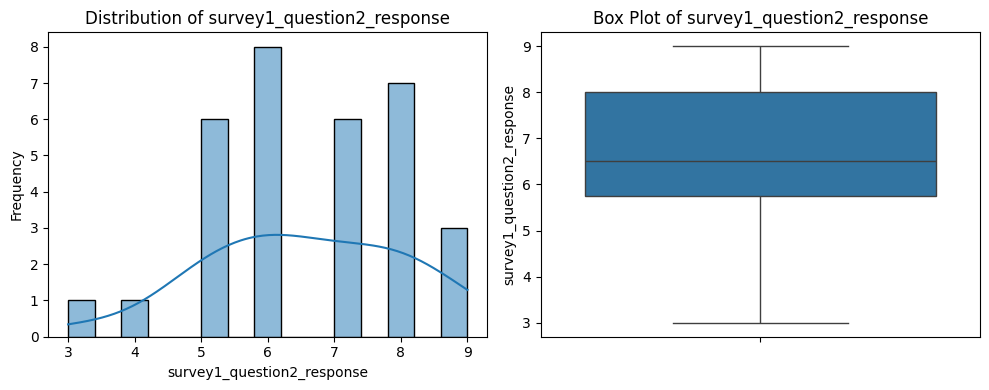

In [18]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

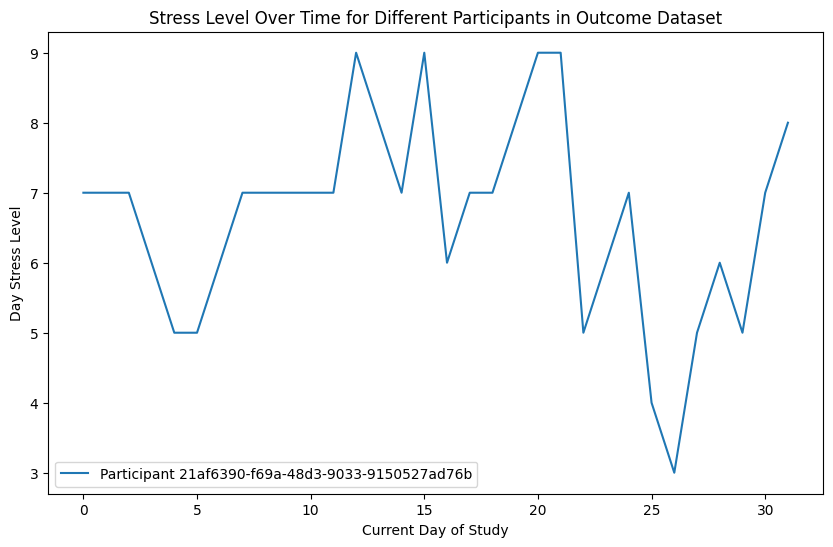

In [19]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6))

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()

#### Scatterplot

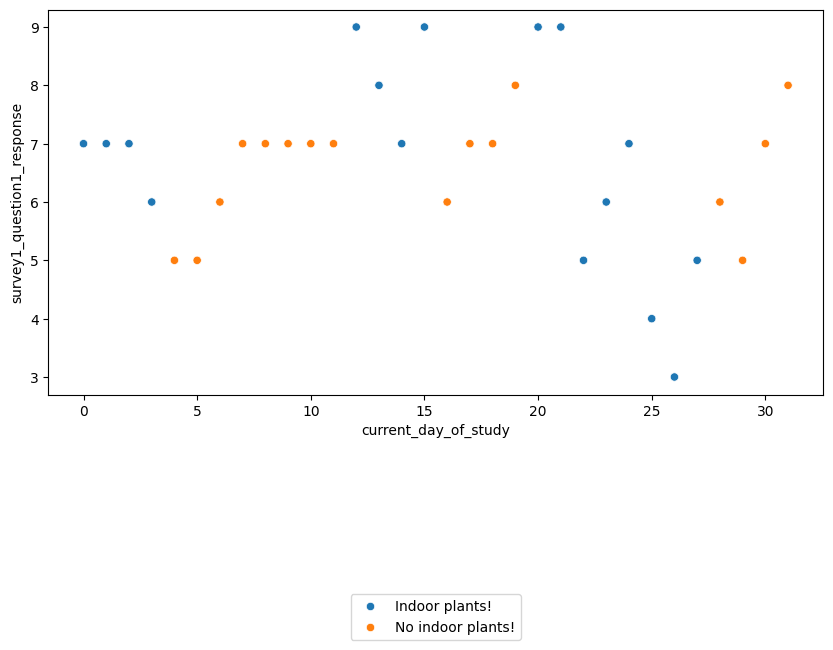

In [20]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))


#### Correlations

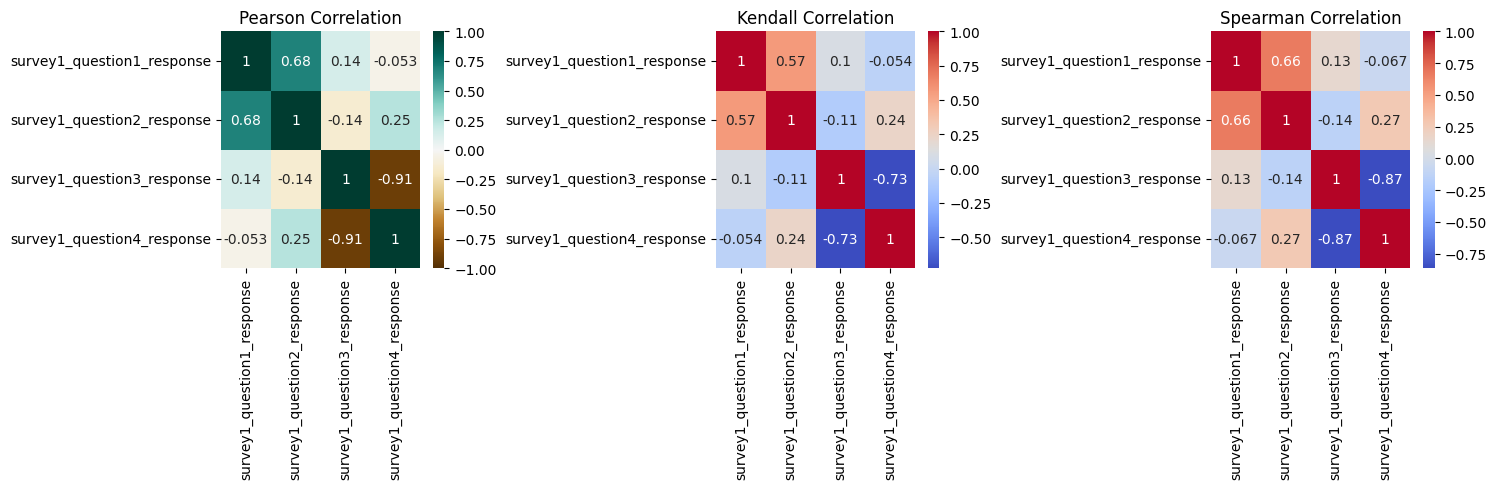

In [21]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Indoor Plants vs No Indoor Plants

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

#### Examination of Outcomes: Today Stress Level

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Indoor plants!",
        "No indoor plants!"
    ])
]

indoor = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Indoor plants!",
    'survey1_question1_response'
]
no_plants = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "No indoor plants!",
    'survey1_question1_response'
]

n_indoor     = indoor.count()
n_no_plants  = no_plants.count()
std_indoor   = indoor.std(ddof=1)
std_no_plants = no_plants.std(ddof=1)

print(f"Indoor plants:        n = {n_indoor}, std = {std_indoor:.2f}, mean = {indoor.mean():.2f}")
print(f"No Indoor plants:     n = {n_no_plants}, std = {std_no_plants:.2f}, mean = {no_plants.mean():.2f}\n")


Indoor plants:        n = 16, std = 1.84, mean = 6.75
No Indoor plants:     n = 16, std = 0.96, mean = 6.56



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [23]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Indoor plants!",
        "No indoor plants!"
    ])
]

indoor = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Indoor plants!",
    'survey1_question2_response'
]
no_plants = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "No indoor plants!",
    'survey1_question2_response'
]

n_indoor     = indoor.count()
n_no_plants  = no_plants.count()
std_indoor   = indoor.std(ddof=1)
std_no_plants = no_plants.std(ddof=1)

print(f"Indoor plants:        n = {n_indoor}, std = {std_indoor:.2f}, mean = {indoor.mean():.2f}")
print(f"No Indoor plants:     n = {n_no_plants}, std = {std_no_plants:.2f}, mean = {no_plants.mean():.2f}\n")


Indoor plants:        n = 16, std = 1.77, mean = 6.25
No Indoor plants:     n = 16, std = 1.15, mean = 6.88



#### Examination of Outcomes: Mean Stress-Relief Score for Indoor Plants (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much doing indoor plants alleviated participants’ stress on days they performed.

In [24]:
df_mea.survey1_question3_text[0]

'How much did this method (having indoor plants in your surroundings) help you feel better about yourself? <b>(1 = Not helpful at all to 10 = Very helpful)  <i>(Answer ONLY if you have had indoor plants around you!)</i></b>'

In [25]:
# 'How much did this method (having indoor plants in your surroundings) help you feel better about yourself? <b>(1 = Not helpful at all to 10 = Very helpful)  <i>(Answer ONLY if you have had indoor plants around you!)</i></b>'
mean_q3_indoor_plants = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Indoor plants!",
    'survey1_question3_response'
].mean()
mean_q3_indoor_plants.item()


6.8125

**Mean Self-Improvement Score for Indoor Plants (Q3): 6.81:**
On days when the participant had indoor plants in her surroundings, she rated Question 3—“How much did this method (having indoor plants in your surroundings) help you feel better about yourself?”—an average of 6.81 out of 10, indicating that having indoor plants provided a moderate benefit.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Doing Indoor Plants (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not have indoor plants.

In [26]:
df_mea.survey1_question4_text[0]

'When you are not practicing the method (not having indoor plants in your surroundings) today, do you feel a lack or difficulty managing your stress? <b>(1 = No difficulty to 10 = Significant difficulty) <i>(Answer ONLY if you have NOT had indoor plants around you!)</i></b>'

In [27]:
# 'When you are not practicing the method (not having indoor plants in your surroundings) today, do you feel a lack or difficulty managing your stress? <b>(1 = No difficulty to 10 = Significant difficulty)(Answer ONLY if you have NOT had indoor plants around you!)'

mean_q4_no_indoor_plants = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "No indoor plants!",
    'survey1_question4_response'
].mean()
mean_q4_no_indoor_plants.item()


5.875

**Mean Stress-Management Difficulty Score Without Indoor Plants (Q4): 5.875:**
On days when the participant did not have indoor plants in her surroundings, she rated Question 4—“When you are not practicing the method (not having indoor plants in your surroundings) today, do you feel a lack or difficulty managing your stress?”—an average of 5.88 out of 10, indicating that going without indoor plants posed a moderate difficulty in managing stress.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [28]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Indoor plants!", "No indoor plants!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Indoor plants!").astype(int)
X = sm.add_constant(df_mea_o['D'])

# OLS Regression
ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.004
Model:                                    OLS   Adj. R-squared:                 -0.029
Method:                         Least Squares   F-statistic:                    0.1299
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.721
Time:                                15:22:11   Log-Likelihood:                -56.729
No. Observations:                          32   AIC:                             117.5
Df Residuals:                              30   BIC:                             120.4
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [29]:
# GLSAR Regression with AR(1) errors (Feasible GLS) 
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.056
Model:                                  GLSAR   Adj. R-squared:                  0.024
Method:                         Least Squares   F-statistic:                     1.722
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.200
Time:                                15:22:11   Log-Likelihood:                -50.330
No. Observations:                          31   AIC:                             104.7
Df Residuals:                              29   BIC:                             107.5
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

#### Bayesian AR(1) Model of Daily Stress Response to Indoor Plants and Mediators

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 183 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.655  0.525    -0.358      1.664      0.026    0.015     393.0   
rho       0.613  0.165     0.334      0.962      0.007    0.006     471.0   
sigma     1.285  0.162     0.970      1.579      0.007    0.007     615.0   

          ess_tail  r_hat  
beta_int     639.0   1.00  
rho          287.0   1.00  
sigma        644.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 1.00%
P(beta_int ≤ –0.5) = 1.00%
P(–0.5 < beta_int < 0) = 9.30%
P(beta_int ≥ 0) = 89.70%


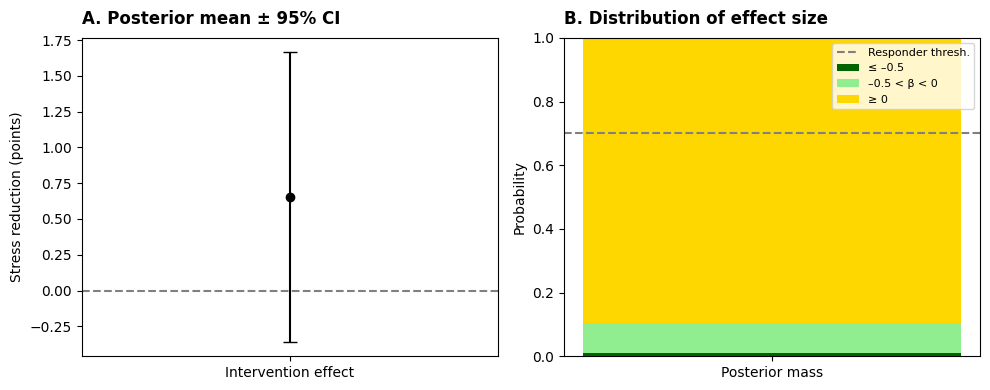

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 538 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.341  0.348    -0.309      1.050      0.014    0.011     617.0   
rho       0.637  0.176     0.346      0.989      0.008    0.006     475.0   
sigma     0.826  0.113     0.641      1.088      0.005    0.005     602.0   
beta_f1   0.607  0.096     0.431      0.795      0.004    0.003     501.0   

          ess_tail  r_hat  
beta_int     664.0   1.00  
rho          404.0   1.01  
sigma        543.0   1.00  
beta_f1      544.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 1.00%
P(beta_int ≤ –0.5) = 1.00%
P(–0.5 < beta_int < 0) = 15.80%
P(beta_int ≥ 0) = 83.20%


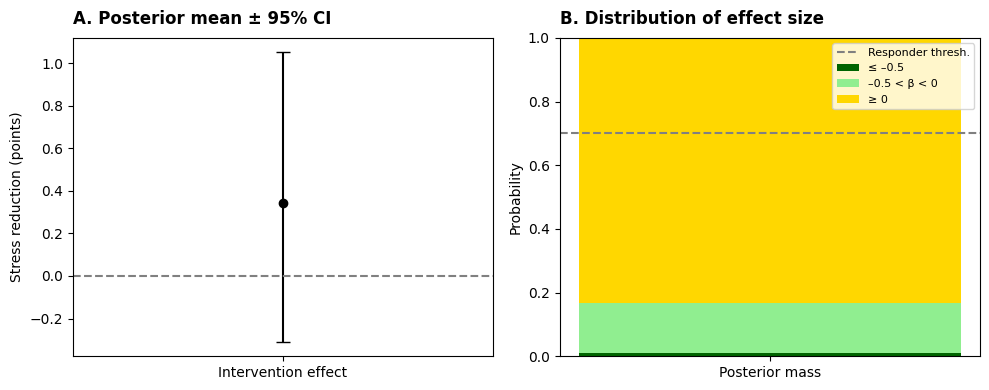

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 843 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.378  0.336    -0.280      1.012      0.013    0.012     698.0   
rho       0.511  0.201     0.112      0.869      0.012    0.006     265.0   
sigma     0.737  0.101     0.577      0.948      0.004    0.003     780.0   
beta_f2   0.686  0.098     0.502      0.869      0.005    0.003     392.0   

          ess_tail  r_hat  
beta_int     601.0   1.00  
rho          299.0   1.01  
sigma        798.0   1.01  
beta_f2      481.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 0.60%
P(beta_int ≤ –0.5) = 0.60%
P(–0.5 < beta_int < 0) = 11.60%
P(beta_int ≥ 0) = 87.80%


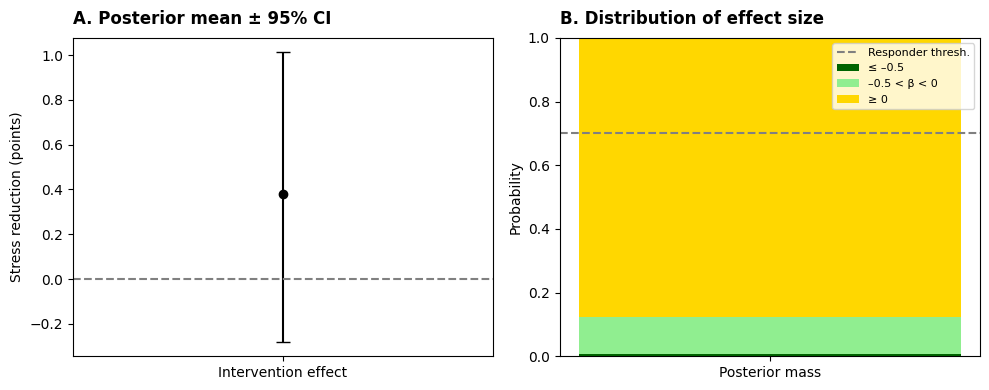

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1207 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.343  0.342    -0.300      1.011      0.012    0.012     821.0   
rho       0.573  0.201     0.224      0.983      0.010    0.007     395.0   
sigma     0.729  0.105     0.546      0.935      0.005    0.005     430.0   
beta_f1   0.204  0.163    -0.117      0.524      0.009    0.007     366.0   
beta_f2   0.496  0.167     0.181      0.833      0.009    0.008     370.0   

          ess_tail  r_hat  
beta_int     582.0   1.00  
rho          234.0   1.00  
sigma        498.0   1.00  
beta_f1      390.0   1.01  
beta_f2      437.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 0.70%
P(beta_int ≤ –0.5) = 0.70%
P(–0.5 < beta_int < 0) = 15.00%
P(beta_int ≥ 0) = 84.30%


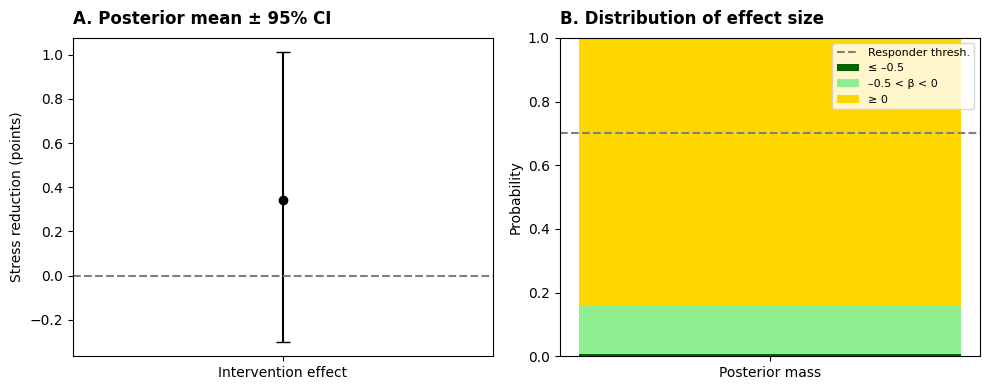

In [30]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Indoor plants!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Model: Only intervention


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 355 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.866  0.620    -0.313      2.068      0.024    0.022     664.0   
rho       0.635  0.159     0.318      0.919      0.008    0.005     395.0   
sigma     1.316  0.180     0.995      1.691      0.007    0.005     675.0   

          ess_tail  r_hat  
beta_int     532.0   1.00  
rho          270.0   1.01  
sigma        674.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 1.60%
P(beta_int ≤ –0.5) = 1.60%
P(–0.5 < beta_int < 0) = 6.40%
P(beta_int ≥ 0) = 92.00%


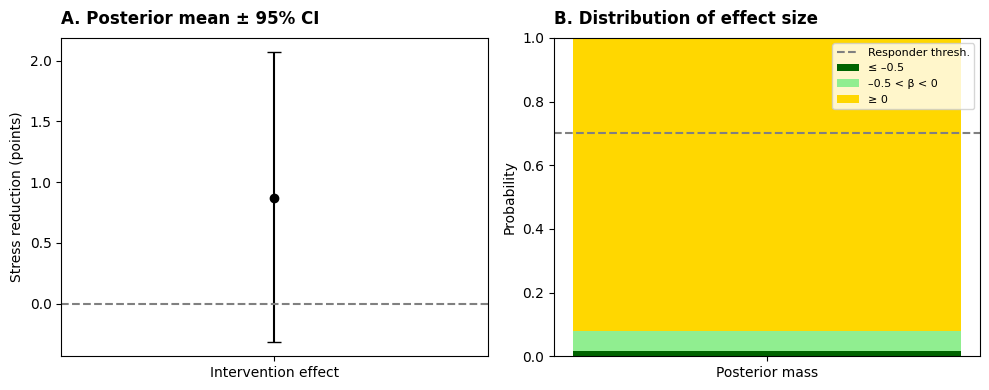


Model: Intervention + fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 444 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.404  0.420    -0.539      1.137      0.020    0.018     470.0   
rho       0.644  0.184     0.325      0.987      0.008    0.005     473.0   
sigma     0.847  0.122     0.643      1.078      0.006    0.006     513.0   
beta_f1   0.637  0.094     0.467      0.824      0.004    0.003     616.0   

          ess_tail  r_hat  
beta_int     252.0    1.0  
rho          330.0    1.0  
sigma        555.0    1.0  
beta_f1      559.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 2.30%
P(beta_int ≤ –0.5) = 2.30%
P(–0.5 < beta_int < 0) = 13.60%
P(beta_int ≥ 0) = 84.10%


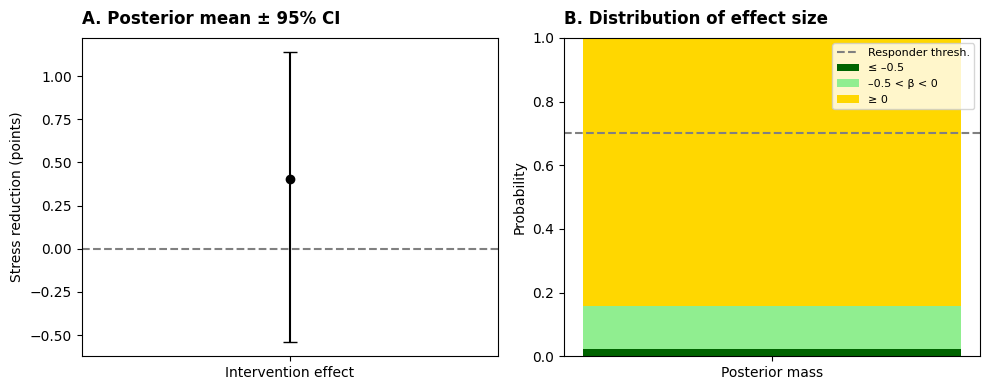


Model: Intervention + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 488 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.439  0.343    -0.197      1.110      0.015    0.011     570.0   
rho       0.533  0.232     0.149      0.994      0.019    0.009     135.0   
sigma     0.744  0.104     0.551      0.938      0.004    0.004     538.0   
beta_f2   0.703  0.098     0.519      0.891      0.005    0.005     377.0   

          ess_tail  r_hat  
beta_int     484.0   1.01  
rho          105.0   1.02  
sigma        453.0   1.00  
beta_f2      385.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 0.40%
P(beta_int ≤ –0.5) = 0.40%
P(–0.5 < beta_int < 0) = 8.90%
P(beta_int ≥ 0) = 90.70%


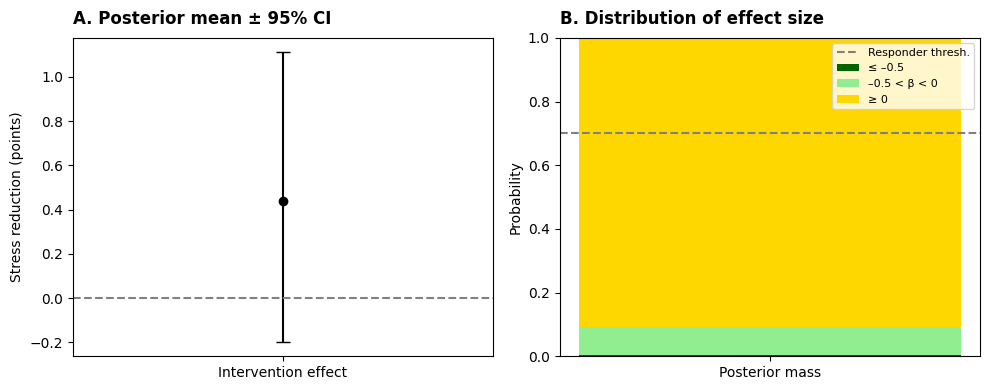


Model: Intervention + fac1 + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 737 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.409  0.344    -0.315      1.038      0.013    0.017     742.0   
rho       0.582  0.210     0.226      0.987      0.009    0.007     486.0   
sigma     0.734  0.103     0.539      0.925      0.004    0.004     609.0   
beta_f1   0.228  0.158    -0.109      0.509      0.007    0.006     527.0   
beta_f2   0.491  0.169     0.162      0.828      0.008    0.007     474.0   

          ess_tail  r_hat  
beta_int     561.0   1.01  
rho          307.0   1.00  
sigma        657.0   1.00  
beta_f1      542.0   1.00  
beta_f2      561.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 0.60%
P(beta_int ≤ –0.5) = 0.60%
P(–0.5 < beta_int < 0) = 9.90%
P(beta_int ≥ 0) = 89.50%


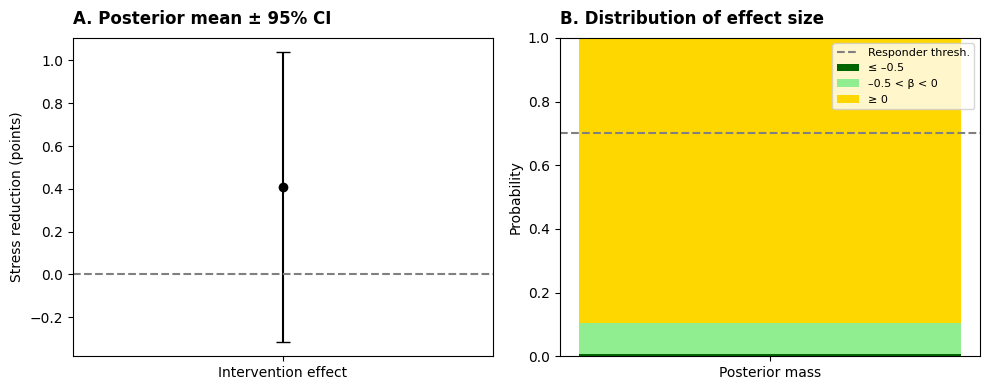

In [31]:
def run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Indoor plants!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    mad = np.median(np.abs(y - np.median(y)))
    scale = max(mad, 2.0)

    with pm.Model() as model:
        beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)
        beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)
        if include_fac1:
            beta_f1 = pm.StudentT('beta_f1', nu=3, mu=0, sigma=scale)
        if include_fac2:
            beta_f2 = pm.StudentT('beta_f2', nu=3, mu=0, sigma=scale)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Only intervention")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False)

print("\nModel: Intervention + fac1")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=False)

print("\nModel: Intervention + fac2")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=True)

print("\nModel: Intervention + fac1 + fac2")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=True)